In [1]:
import os

import pandas as pd
import numpy as np

from dotenv import load_dotenv
from nixtlats import TimeGPT
from IPython.display import Markdown

os.chdir("../usage")
from usageUtils import getUsage

load_dotenv()

True

In [2]:
timegpt = TimeGPT(token=os.getenv("TIMEGPT_TOKEN"))

timegpt.validate_token()

INFO:nixtlats.timegpt:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


True

In [3]:
# Get current API token usage data

getUsage()

Current usage data:

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  56   ||   TOKENS:  198698   ||   SPENT:  313.40          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [4]:
# DATA PREP: Create dataframe from csv file, convert 'TimePeriod' column to timezone-naive datetime, remove uneccessary columns, save to csv file, create new dataframe from csv file, return new dataframe

def dataPrep(dfName, csvName, timeCol, dropCols, csvNameUpdate):
    dfName = pd.read_csv(csvName)
    dfName[timeCol] = pd.to_datetime(dfName[timeCol]).dt.tz_localize(None)
    dfName = dfName.drop(columns=dropCols)
    dfName.to_csv(csvNameUpdate, index=False)
    dfName = pd.read_csv(csvNameUpdate)
    return dfName

# Input sample data params and run data prep function

df = dataPrep(
    dfName="df",
    csvName="../data/raw/billing2_raw.csv",
    timeCol="TimePeriod",
    dropCols=["Tenant"],
    csvNameUpdate="../data/clean/billing2_clean.csv"
)

display(df.head())

,TimePeriod,ProratedQuantity
0,2023-09-14,93218.526165
1,2023-09-15,104783.771445
2,2023-09-16,97060.344313
3,2023-09-17,96852.455640
4,2023-09-18,110037.811158


INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


### Anomalies Detection Result (Default 99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99
0,2023-10-16,0,103994.822541,123016.968750,142039.114959
1,2023-10-17,0,110264.611604,129286.757812,148308.904021
2,2023-10-18,0,112312.760041,131334.906250,150357.052459
3,2023-10-19,0,107988.775666,127010.921875,146033.068084
4,2023-10-20,0,107433.963166,126456.109375,145478.255584
...,...,...,...,...,...
142,2024-03-06,0,49269.064729,68291.210938,87313.357146
143,2024-03-07,0,49232.056916,68254.203125,87276.349334
144,2024-03-08,0,48854.353791,67876.500000,86898.646209
145,2024-03-09,0,48782.830354,67804.976562,86827.122771


### Detected Anomalies (Default 99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99
8,2023-10-24,1,104763.041291,123785.187500,142807.333709
9,2023-10-25,1,107263.025666,126285.171875,145307.318084
10,2023-10-26,1,102314.541291,121336.687500,140358.833709
12,2023-10-28,1,100271.611604,119293.757812,138315.904021
13,2023-10-29,1,100967.260041,119989.406250,139011.552459
18,2023-11-03,1,83249.103791,102271.250000,121293.396209


### Results Comparison Plot (Default 99% Prediction Interval Level)

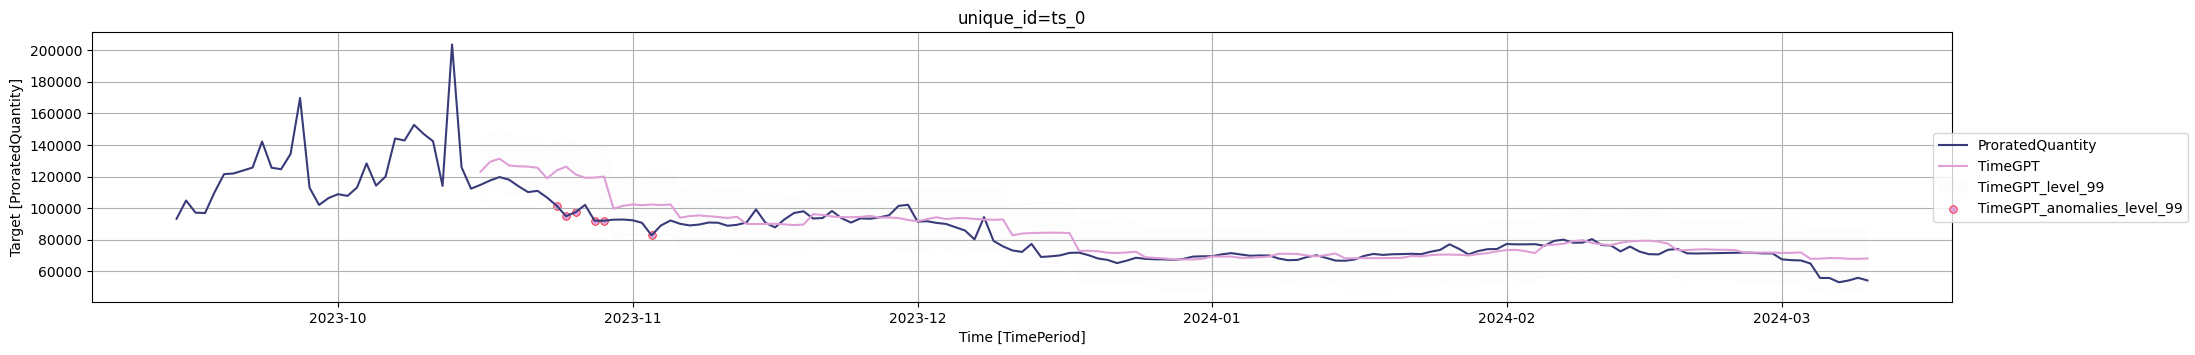

In [5]:
# Run anomaly detection model, plot results compared with original data (default prediction interval level is 99)

dfAnoms = timegpt.detect_anomalies(
    df, time_col="TimePeriod", target_col="ProratedQuantity", freq="D"
)

dfAnomsOnly = dfAnoms[dfAnoms["anomaly"] == 1]

plotAnoms = timegpt.plot(
    df, dfAnoms, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (Default 99% Prediction Interval Level)"),
    dfAnoms,
    Markdown("### Detected Anomalies (Default 99% Prediction Interval Level)"),
    dfAnomsOnly,
    Markdown("### Results Comparison Plot (Default 99% Prediction Interval Level)"),
    plotAnoms,
)

In [6]:
getUsage(update=True)

Usage data successfully updated with:               

<<  1 call  •  914 tokens  •  2.57 spent  >>

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  57   ||   TOKENS:  199612   ||   SPENT:  315.97          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [7]:
# Get historical prediction intervals to test against detected anomalies

dfFcst = timegpt.forecast(
    df, h=1, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", add_history=True, level=[99, 90, 99.99],
)

dfFcst = dfFcst.merge(df)

for lv in [99, 90, 99.99]:
    dfFcst[f"anomaly_{lv}"] = (
        dfFcst["ProratedQuantity"] > dfFcst[f"TimeGPT-hi-{lv}"]
    ) | (
        dfFcst["ProratedQuantity"] < dfFcst[f"TimeGPT-lo-{lv}"]
    )

    dfFcst[f"anomaly_{lv}"] = dfFcst[f"anomaly_{lv}"].astype(np.int64)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Calling Historical Forecast Endpoint...


In [8]:
getUsage(update=True)

Usage data successfully updated with:               

<<  2 calls  •  1541 tokens  •  4.22 spent  >>

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  59   ||   TOKENS:  201153   ||   SPENT:  320.19          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [9]:
# Test detected anomalies against historical prediction intervals defalut level 99

pd.testing.assert_series_equal(
    dfFcst["anomaly_99"],
    dfAnoms.merge(df)["anomaly"],
    check_index=False,
    check_names=False,
)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


### Anomalies Detection Result (90% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-90,TimeGPT,TimeGPT-hi-90
0,2023-10-16,0,110869.950257,123016.968750,135163.987243
1,2023-10-17,0,117139.739320,129286.757812,141433.776305
2,2023-10-18,0,119187.887757,131334.906250,143481.924743
3,2023-10-19,0,114863.903382,127010.921875,139157.940368
4,2023-10-20,1,114309.090882,126456.109375,138603.127868
...,...,...,...,...,...
142,2024-03-06,1,56144.192445,68291.210938,80438.229430
143,2024-03-07,1,56107.184632,68254.203125,80401.221618
144,2024-03-08,1,55729.481507,67876.500000,80023.518493
145,2024-03-09,0,55657.958070,67804.976562,79951.995055


### Detected Anomalies (90% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99
8,2023-10-24,1,104763.041291,123785.187500,142807.333709
9,2023-10-25,1,107263.025666,126285.171875,145307.318084
10,2023-10-26,1,102314.541291,121336.687500,140358.833709
12,2023-10-28,1,100271.611604,119293.757812,138315.904021
13,2023-10-29,1,100967.260041,119989.406250,139011.552459
18,2023-11-03,1,83249.103791,102271.250000,121293.396209


### Results Comparison Plot (90% Prediction Interval Level)

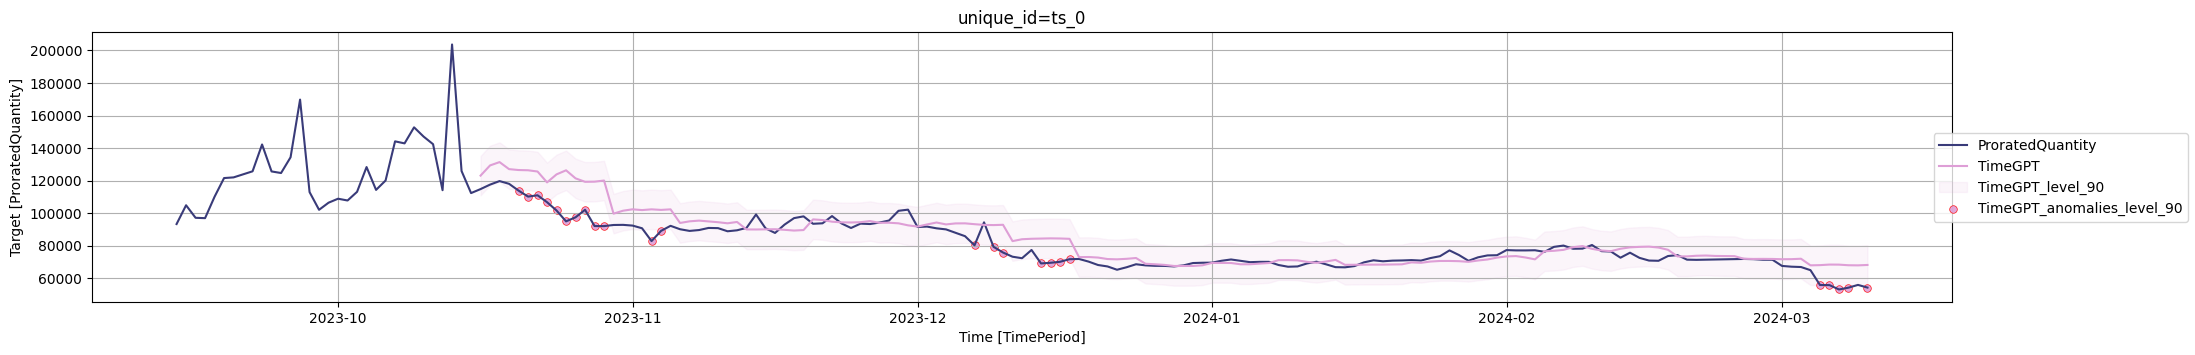

In [10]:
# Run anomaly detection model, plot results compared with original data (prediction interval level 90 should identify more anomalies)

dfAnoms90 = timegpt.detect_anomalies(
    df, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", level=90
)

dfAnomsOnly90 = dfAnoms[dfAnoms["anomaly"] == 1]

plotAnoms90 = timegpt.plot(
    df, dfAnoms90, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (90% Prediction Interval Level)"),
    dfAnoms90,
    Markdown("### Detected Anomalies (90% Prediction Interval Level)"),
    dfAnomsOnly90,
    Markdown("### Results Comparison Plot (90% Prediction Interval Level)"),
    plotAnoms90,
)

In [11]:
getUsage(update=True)

Usage data successfully updated with:               

<<  1 call  •  914 tokens  •  2.57 spent  >>

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  60   ||   TOKENS:  202067   ||   SPENT:  322.76          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [12]:
# Test detected anomalies against historical prediction interval level 90

pd.testing.assert_series_equal(
    dfFcst["anomaly_90"],
    dfAnoms90.merge(df)["anomaly"],
    check_index=False,
    check_names=False,
)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


### Anomalies Detection Result (99.99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99.99,TimeGPT,TimeGPT-hi-99.99
0,2023-10-16,0,94285.482218,123016.968750,151748.455282
1,2023-10-17,0,100555.271280,129286.757812,158018.244345
2,2023-10-18,0,102603.419718,131334.906250,160066.392782
3,2023-10-19,0,98279.435343,127010.921875,155742.408407
4,2023-10-20,0,97724.622843,126456.109375,155187.595907
...,...,...,...,...,...
142,2024-03-06,0,39559.724405,68291.210938,97022.697470
143,2024-03-07,0,39522.716593,68254.203125,96985.689657
144,2024-03-08,0,39145.013468,67876.500000,96607.986532
145,2024-03-09,0,39073.490030,67804.976562,96536.463095


### Detected Anomalies (99.99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99.99,TimeGPT,TimeGPT-hi-99.99
9,2023-10-25,1,97553.685343,126285.171875,155016.658407


### Results Comparison Plot (99.99% Prediction Interval Level)

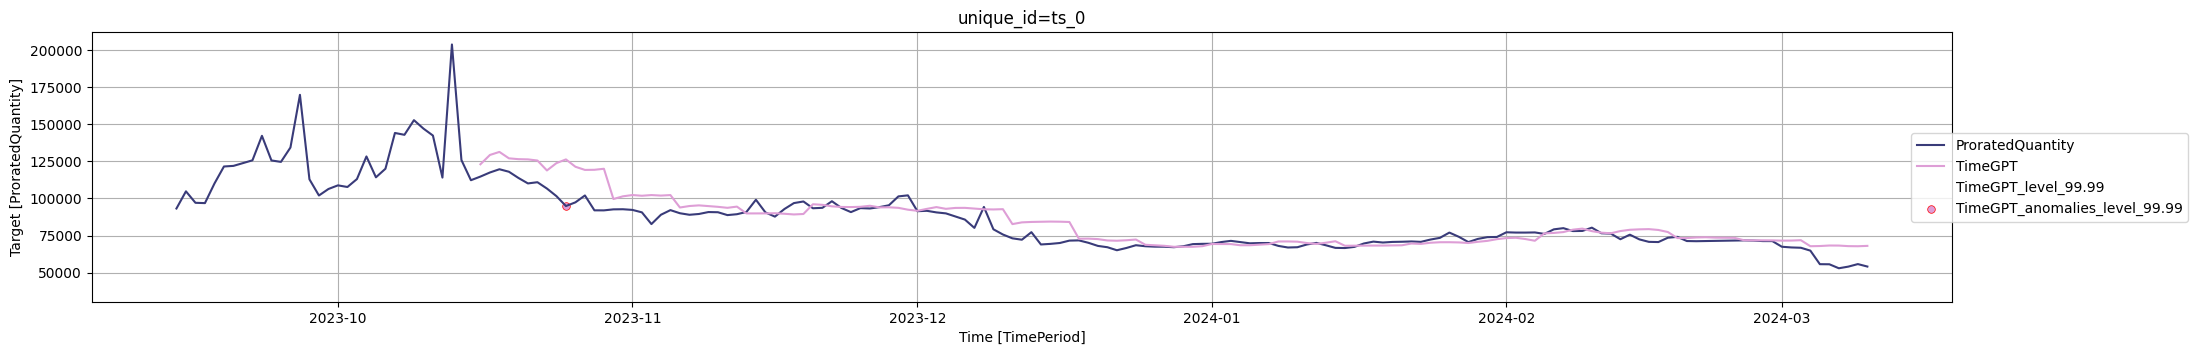

In [13]:
# Run anomaly detection model, plot results compared with original data (prediction interval level 99.99 should identify fewer anomalies)

dfAnoms99_99 = timegpt.detect_anomalies(
    df, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", level=99.99,
)

dfAnomsOnly99_99 = dfAnoms99_99[dfAnoms99_99["anomaly"] == 1]

plotAnoms99_99 = timegpt.plot(
    df, dfAnoms99_99, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (99.99% Prediction Interval Level)"),
    dfAnoms99_99,
    Markdown("### Detected Anomalies (99.99% Prediction Interval Level)"),
    dfAnomsOnly99_99,
    Markdown("### Results Comparison Plot (99.99% Prediction Interval Level)"),
    plotAnoms99_99,
)

In [14]:
getUsage(update=True)

Usage data successfully updated with:               

<<  1 call  •  914 tokens  •  2.57 spent  >>

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  61   ||   TOKENS:  202981   ||   SPENT:  325.33          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [15]:
# Test detected anomalies against historical prediction interval level 99.99

pd.testing.assert_series_equal(
    dfFcst["anomaly_99.99"],
    dfAnoms99_99.merge(df)["anomaly"],
    check_index=False,
    check_names=False,
)

In [16]:
# Get historical prediction intervals to test against detected anomalies with exogenous variables

dfFcstX = timegpt.forecast(
    df, h=1, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", add_history=True, date_features=True, level=[99, 90, 99.99],
)

dfFcstX = dfFcstX.merge(df)

for lv in [99, 90, 99.99]:
    dfFcstX[f"anomaly_{lv}"] = (
        dfFcstX["ProratedQuantity"] > dfFcstX[f"TimeGPT-hi-{lv}"]
    ) | (
        dfFcstX["ProratedQuantity"] < dfFcstX[f"TimeGPT-lo-{lv}"]
    )

    dfFcstX[f"anomaly_{lv}"] = dfFcstX[f"anomaly_{lv}"].astype(np.int64)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Using the following exogenous variables: year_2023, year_2024, month_1, month_2, month_3, month_9, month_10, month_11, month_12, day_1, day_2, day_3, day_4, day_5, day_6, day_7, day_8, day_9, day_10, day_11, day_12, day_13, day_14, day_15, day_16, day_17, day_18, day_19, day_20, day_21, day_22, day_23, day_24, day_25, day_26, day_27, day_28, day_29, day_30, day_31, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Calling Historical Forecast Endpoint...


In [18]:
getUsage(update=True)

Usage data successfully updated with:               

<<  1 call  •  9815 tokens  •  14.13 spent  >>

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  63   ||   TOKENS:  221442   ||   SPENT:  349.85          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...
INFO:nixtlats.timegpt:Using the following exogenous variables: year_2023, year_2024, month_1, month_2, month_3, month_9, month_10, month_11, month_12, day_1, day_2, day_3, day_4, day_5, day_6, day_7, day_8, day_9, day_10, day_11, day_12, day_13, day_14, day_15, day_16, day_17, day_18, day_19, day_20, day_21, day_22, day_23, day_24, day_25, day_26, day_27, day_28, day_29, day_30, day_31, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6


### Anomalies Detection Result (99.99% Prediction Interval Level with Exogeneous Variables)

,TimePeriod,anomaly,TimeGPT-lo-99.99,TimeGPT,TimeGPT-hi-99.99
0,2023-10-16,0,91937.120403,121069.076552,150201.032701
1,2023-10-17,0,99008.680713,128140.636862,157272.593011
2,2023-10-18,0,98832.490707,127964.446856,157096.403005
3,2023-10-19,0,95033.405559,124165.361708,153297.317857
4,2023-10-20,0,94146.206341,123278.162490,152410.118638
...,...,...,...,...,...
142,2024-03-06,0,38673.495067,67805.451216,96937.407365
143,2024-03-07,0,36460.750340,65592.706489,94724.662638
144,2024-03-08,0,36622.928887,65754.885036,94886.841185
145,2024-03-09,0,36832.357619,65964.313768,95096.269917


### Detected Anomalies (99.99% Prediction Interval Level with Exogeneous Variables)

,TimePeriod,anomaly,TimeGPT-lo-99.99,TimeGPT,TimeGPT-hi-99.99
9,2023-10-25,1,96108.279769,125240.235918,154372.192067


### Results Comparison Plot (99.99% Prediction Interval Level with Exogeneous Variables)

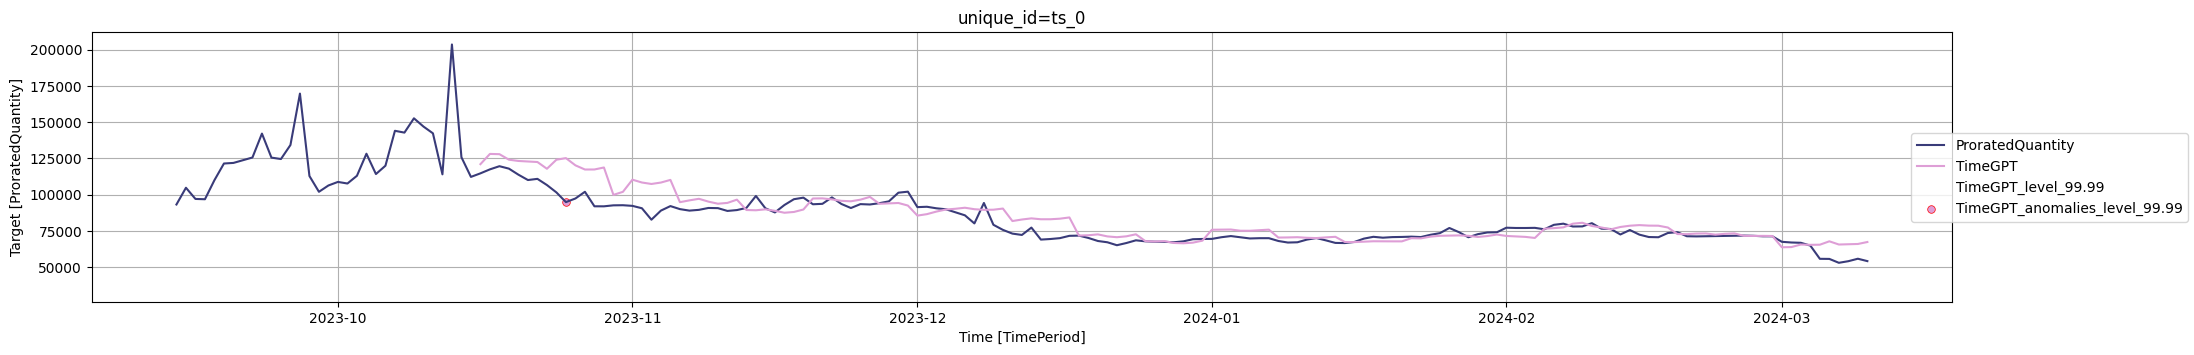

In [19]:
# Run anomaly detection model with exogeneous variables, plot results compared with original data (prediction interval level 99.99 should identify fewer anomalies)

dfAnomsX99_99 = timegpt.detect_anomalies(
    df, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", date_features=True, level=99.99,
)

dfAnomsOnlyX99_99 = dfAnomsX99_99[dfAnomsX99_99["anomaly"] == 1]

plotAnomsX99_99 = timegpt.plot(
    df, dfAnomsX99_99, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (99.99% Prediction Interval Level with Exogeneous Variables)"),
    dfAnomsX99_99,
    Markdown("### Detected Anomalies (99.99% Prediction Interval Level with Exogeneous Variables)"),
    dfAnomsOnlyX99_99,
    Markdown("### Results Comparison Plot (99.99% Prediction Interval Level with Exogeneous Variables)"),
    plotAnomsX99_99,
)

In [20]:
getUsage(update=True)

Usage data successfully updated with:               

<<  1 call  •  9327 tokens  •  12.66 spent  >>

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  64   ||   TOKENS:  230769   ||   SPENT:  362.51          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [21]:
# Test detected anomalies with exogeneous variables against historical prediction interval level 99.99

pd.testing.assert_series_equal(
    dfFcstX["TimeGPT-lo-99.99"],
    dfAnomsX99_99.merge(df)["TimeGPT-lo-99.99"],
    check_index=False,
    check_names=False,
    rtol=1,
    atol=1,
)